# Anisotropic diffusion equation in 1D example

In [1]:
using LinearAlgebra
using Printf
using Plots

In [2]:
pwd()

"/home/dean/Documents/SBP_operators/notebooks"

In [3]:
cd("..")
using Pkg
Pkg.activate(".")
using SBP_operators

$$ u_{n+1} = u_n + \Delta t F(u_{n+1}) $$


$$
\begin{align}
    u^0 = u_n\\
    \text{for k = 1:N}\\
        u^{k+1} = u^k - \alpha(u^k - u_n - \Delta t F(u^k)) \\
        norm(u^{k+1} - u^{k}) < tol \\
    \text{end} \\
    u^{n+1} = u_n + \Delta t F((u^{k+1} + u^{n})/2)
\end{align}
$$

Time solver

In [4]:
function time_solver(soln,RHS,n,x,Δt,Δx,k,t_f,boundary;method=:euler,order=2)

    N = ceil(Int64,t_f/Δt)
    
    # Eulers method
    for i = 1:N-1
        t = i*Δt
        if method == :euler
            u[:,i+1] = u[:,i] + Δt*RHS(u[:,i+1],u[:,i],n,Δx,Δt,k,t,x,boundary,order=order)

        elseif method == :rk4
            k1 = RHS(u[:,i+1],u[:,i]        ,n,Δx,Δt,k,t        ,x,boundary,order=order)
            k2 = RHS(u[:,i+1],u[:,i]+Δt/2*k1,n,Δx,Δt,k,t+0.5Δt  ,x,boundary,order=order)
            k3 = RHS(u[:,i+1],u[:,i]+Δt/2*k2,n,Δx,Δt,k,t+0.5Δt  ,x,boundary,order=order)
            k4 = RHS(u[:,i+1],u[:,i]+Δt*k3  ,n,Δx,Δt,k,t+Δt     ,x,boundary,order=order)

            u[:,i+1] = u[:,i] + Δt/6 * (k1 + 2k2 + 2k3 + k4)

        elseif method == :impliciteuler

            uⱼ = u[:,i]
            for j = 1:100
                uⱼ = uⱼ - 1.5Δt *(uⱼ - u[:,i] - Δt*RHS(u[:,i+1],uⱼ,n,Δx,Δt,k,t,x,boundary,order=order))
            end
            u[:,i+1] = u[:,i] + Δt * RHS(u[:,i+1], uⱼ, n,Δx,Δt,k,t,x,boundary,order=order)

        end
    end

    return soln
end

time_solver (generic function with 1 method)

Going to solve the diffusion equation,
$$
    \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(k \frac{\partial u}{\partial x}\right),
$$
with no-flux boundary conditions,
$$
    \frac{\partial}{\partial x} u(0,t) = 0,  \qquad \frac{\partial}{\partial x} u(L,t) = 0
$$
and initial condition,
$$
    u(x,0) = \exp(-(x-0.5)^2/0.02)
$$

The SAT is,
$$
    SAT_0 = \tau_0 H^{-1} B (D_x u - f) = \tau_0 (h_{ii} \Delta x)^{-1} (D_x u)_{ii},
$$
where $B = E_N - E_0$ and where $\tau_0 \geq 0$

In [5]:
function rate(uₓₓ,u,n,Δx,Δt,k,t,x,g;order=2)

    # Compute the second derivative
    uₓₓ = SBP_operators.Dₓₓ!(uₓₓ,u,k,n,Δx,order=order)

    # uₓ = 0.0*u
    # uₓ = SBP_operators.Dₓ!(uₓ,u,n,Δx,order=order)

    SAT = SBP_operators.Neumann(u,Δx,g,c=k,order=order)

    # SAT terms
    uₓₓ[1] += SAT[1]
    uₓₓ[end] += SAT[end]

    return uₓₓ

end



rate (generic function with 1 method)

Set the initial parameters for the simulation

In [6]:
# Spatial domain
𝒟 = [0.0,1.0]
n =  51
Δx = 𝒟[2]/(n-1)
x = collect(range(𝒟[1],𝒟[2],step=Δx))

k = zeros(Float64,n+1) .+ 1.0

# Time domain
Δt = 0.1 * Δx^2
t_f = 400*Δt #Length of the simulation
N = ceil(Int64,t_f/Δt) #Time steps in simulation

u₀(x) = exp.(-(x.-0.5).^2 ./0.02) #Set initial condition

ϕ = [0.0,0.0] #Set the boundary conditions

order = 6 #Order of the integrator
method = :euler #Time stepping method

println("Δx=",Δx,"      ","Δt=",Δt,"        ","final time=",t_f)

Δx=0.02      Δt=4.0e-5        final time=0.016


Run the simulation

In [7]:
u = zeros(Float64,length(x),N)
u[:,1] = u₀(x);

# plot(x,u[:,1])

51-element Vector{Float64}:
 3.726653172078671e-6
 9.929504305851081e-6
 2.5419346516199247e-5
 6.252150377482026e-5
 0.0001477483602320339
 0.00033546262790251126
 0.0007318024188804728
 0.0015338106793244643
 0.0030887154082367744
 0.005976022895005943
 ⋮
 0.0030887154082367744
 0.0015338106793244643
 0.0007318024188804728
 0.00033546262790251126
 0.00014774836023203337
 6.252150377482037e-5
 2.541934651619929e-5
 9.929504305851081e-6
 3.726653172078671e-6

In [8]:
soln = time_solver(u,rate,n,x,Δt,Δx,k,t_f,ϕ,method=method);

┌ Info: Saved animation to 
│   fn = /home/dean/Documents/SBP_operators/yes.gif
└ @ Plots /home/dean/.julia/packages/Plots/PomtQ/src/animation.jl:114


Plots.AnimatedGif("/home/dean/Documents/SBP_operators/yes.gif")
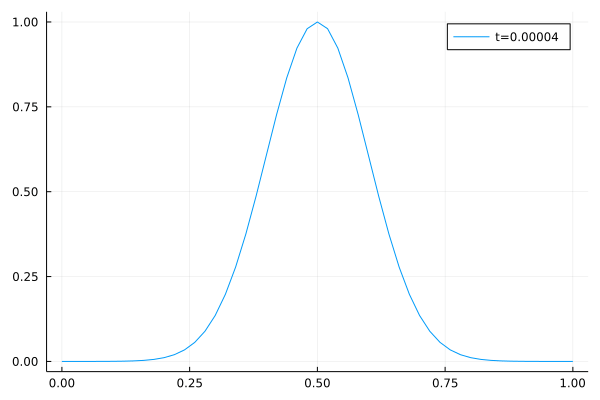

In [9]:
anim = @animate for i=1:N
    plot(x,u[:,i],label="t=$(@sprintf("%.5f",i*Δt))")
end


gif(anim,"yes.gif",fps=15)

---
# Second one

Going to solve the diffusion equation,
$$
    \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(k \frac{\partial u}{\partial x}\right),
$$
with Dirichlet boundary conditions,
$$
    u(0,t) = \phi_0,  \qquad u(L,t) = \phi_L
$$
and initial condition,
$$
    u(x,0) = \exp(-(x-0.5)^2/0.02).
$$

The RHS of the PDE with the included boundary term is $k\partial_{xx} u + SAT$. There are two SATs required:
$$
    SAT_0 = \tau_0 H^{-1}B^T H^{-1} B(u - f) = \tau_0 (h_{ii} \Delta x)^{-2} (u_i - f_i), 
$$
The second SAT is a bit more complicated,
$$
\begin{align}
    SAT_1 &= \alpha_0 H^{-1} (K H D_x)^T H^{-1} B u = \alpha_0 H^{-1} (D_x)^T K B u, \\
        &= \alpha_0 H^{-1} (D_x)^T B u = \alpha_0 H^{-1} (D_x)^T K (e_Nu^T - e_0 u^T),
\end{align}
$$
For second order case we have
$$
    (D_x^{(2)})^T K B u = (D_x^{(2)})^T [k_0 u_0, 0, \dots, 0, k_N u_N] = \frac{1}{\Delta x} [-k_0 u_0, -k_0 u_0, \dots, 0, k_N u_n, k_N u_N]^T
$$
where $i=0,1,\dots,O-1$ or $N-O,N-O+1,\dots,N$ where $O$ is the order of the method and $\tau_0 = -(1 + \tau_1)$, $\tau_1 \geq 0$ and $\alpha_0=1$. 

In [10]:
function rate(uₓₓ,u,n,Δx,Δt,k,t,x,g;order=2)

    # Compute the second derivative
    uₓₓ = SBP_operators.Dₓₓ!(uₓₓ,u,k,n,Δx,order=order)

    # SAT terms
    SAT = SBP_operators.Dirichlet(u,Δx,g,c=k,order=order)

    uₓₓ[1:order] += SAT[1:order]
    uₓₓ[end-order+1:end] += SAT[end-order+1:end]


    return uₓₓ

end

rate (generic function with 1 method)

Define the domain, initial condition and time steps

In [11]:
# Spatial domain
𝒟 = [0.0,1.0]
n =  51
Δx = 𝒟[2]/(n-1)
x = collect(range(𝒟[1],𝒟[2],step=Δx))

k = zeros(Float64,n+1) .+ 8.0

# Time domain
Δt = 10.0 * Δx^2
t_f = 50*Δt #Length of the simulation
N = ceil(Int64,t_f/Δt) #Time steps in simulation

u₀(x) = exp.(-(x.-0.5).^2 ./0.02) #Set initial condition

ϕ = [1.0,0.0] #Set the boundary conditions

order = 2 #Order of the integrator
method = :impliciteuler #Time stepping method

println("Δx=",Δx,"      ","Δt=",Δt,"        ","final time=",t_f)

Δx=0.02      Δt=0.004        final time=0.2


Set the initial condition and run the simulation

In [12]:
u = zeros(Float64,length(x),N)
u[:,1] = u₀(x)
u[1,1] = ϕ[1]
u[end,1] = ϕ[end]

soln = time_solver(u,rate,n,x,Δt,Δx,k,t_f,ϕ,method=method,order=order);

┌ Info: Saved animation to 
│   fn = /home/dean/Documents/SBP_operators/yes.gif
└ @ Plots /home/dean/.julia/packages/Plots/PomtQ/src/animation.jl:114


Plots.AnimatedGif("/home/dean/Documents/SBP_operators/yes.gif")
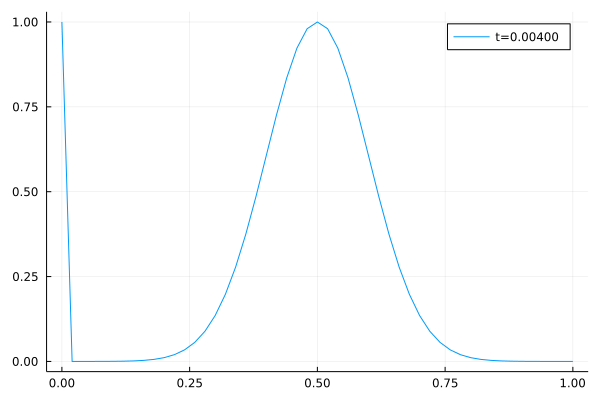

In [13]:
anim = @animate for i=1:N
    plot(x,u[:,i],label="t=$(@sprintf("%.5f",i*Δt))")
end


gif(anim,"yes.gif",fps=5)

---
# Problem 3: Mixed boundaries

Going to solve the diffusion equation,
$$
    \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(k \frac{\partial u}{\partial x}\right),
$$
with Dirichlet boundary conditions,
$$
    u(0,t) = \phi_0,  \qquad \frac{\partial}{\partial x} u(L,t) = 0
$$
and initial condition,
$$
    u(x,0) = \exp(-(x-0.5)^2/0.02).
$$

The RHS of the PDE with the included boundary term is $k\partial_{xx} u + SAT$. There are two SATs required:
$$
    SAT_0 = \tau_0 H^{-1}B^T H^{-1} B(u - f) = \tau_0 (h_{ii} \Delta x)^{-2} (u_i - f_i), 
$$
The second SAT is a bit more complicated,
$$
\begin{align}
    SAT_1 &= \alpha_0 H^{-1} (K H D_x)^T H^{-1} B u = \alpha_0 H^{-1} (D_x)^T K B u, \\
        &= \alpha_0 H^{-1} (D_x)^T B u = \alpha_0 H^{-1} (D_x)^T K (e_Nu^T - e_0 u^T),
\end{align}
$$
For second order case we have
$$
    (D_x^{(2)})^T K B u = (D_x^{(2)})^T [k_0 u_0, 0, \dots, 0, k_N u_N] = \frac{1}{\Delta x} [-k_0 u_0, -k_0 u_0, \dots, 0, k_N u_n, k_N u_N]^T
$$
where $i=0,1,\dots,O-1$ or $N-O,N-O+1,\dots,N$ where $O$ is the order of the method and $\tau_0 = -(1 + \tau_1)$, $\tau_1 \geq 0$ and $\alpha_0=1$. 

In [14]:
function rate(uₓₓ,u,n,Δx,Δt,k,t,x,g;order=2)

    uₓₓ = SBP_operators.Dₓₓ!(uₓₓ,u,k,n,Δx,order=order)

    # Penalty parameters left hand
    SATₗ = SBP_operators.SAT_left(:Dirichlet,u,Δx,g,c=k,order=order)

    SATᵣ = SBP_operators.SAT_right(:Neumann,u,Δx,g,c=k,order=order)

    uₓₓ[1:order] += SATₗ[1:order]
    uₓₓ[end] += SATᵣ[end]

    # Return
    return uₓₓ
end

rate (generic function with 1 method)

In [15]:
# Spatial domain
𝒟 = [0.0,1.0]
n =  21
Δx = 𝒟[2]/(n-1)
x = collect(range(𝒟[1],𝒟[2],step=Δx))

k = zeros(Float64,n) .+ 1.0

# Time domain
Δt = 0.1 * Δx^2
t_f = 100*Δt #Length of the simulation
N = ceil(Int64,t_f/Δt) #Time steps in simulation

u₀(x) = exp.(-(x.-0.5).^2 ./0.02) #Set initial condition

ϕ = [1.0,0.0] #Set the boundary conditions

order = 2 #Order of the integrator
method = :euler #Time stepping method

println("Δx=",Δx,"      ","Δt=",Δt,"        ","final time=",t_f)

Δx=0.05      Δt=0.00025000000000000006        final time=0.025000000000000005


In [16]:
u = zeros(Float64,length(x),N)
u[:,1] = u₀(x)
u[1,1] = ϕ[1]
u[end,1] = ϕ[end]

soln = time_solver(u,rate,n,x,Δt,Δx,k,t_f,ϕ,method=method);

┌ Info: Saved animation to 
│   fn = /home/dean/Documents/SBP_operators/yes.gif
└ @ Plots /home/dean/.julia/packages/Plots/PomtQ/src/animation.jl:114


Plots.AnimatedGif("/home/dean/Documents/SBP_operators/yes.gif")
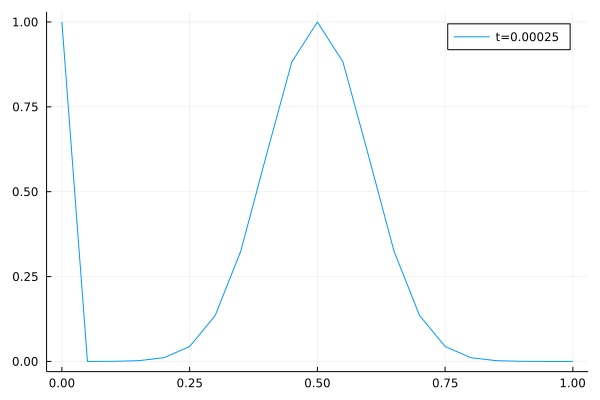

In [17]:
anim = @animate for i=1:N
    plot(x,u[:,i],label="t=$(@sprintf("%.5f",i*Δt))")
end


gif(anim,"yes.gif",fps=5)

---
# Problem 4: Robin boundaries

Going to solve the diffusion equation,
$$
    \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(k \frac{\partial u}{\partial x}\right),
$$
with Robin boundary conditions,
$$
    \beta_0 \frac{\partial}{\partial x}u(0,t) + \alpha_0 u(0,t) = \phi_0,  \qquad \beta_N \frac{\partial}{\partial x} u(L,t) + \alpha_N u(L,t) = 0,
$$
where $\alpha_0 = \alpha_N = \beta_0 = \beta_N = 1$ and initial condition,
$$
    u(x,0) = \exp(-(x-0.5)^2/0.02).
$$

In [18]:
function rate(uₓₓ,u,n,Δx,Δt,k,t,x,g;order=2)
    uₓₓ = SBP_operators.Dₓₓ!(uₓₓ,u,k,n,Δx,order=order)

    α₀ = β₀ = 1.0
    αₙ = βₙ = 1.0

    SATₗ = SBP_operators.SAT_left(:Robin,u,Δx,g,c=k,order=order,a=α₀,b=β₀)
    SATᵣ = SBP_operators.SAT_left(:Robin,u,Δx,g,c=k,order=order,a=αₙ,b=βₙ)

    uₓₓ[1:order] += SATₗ
    uₓₓ[end-order+1:end] += SATᵣ

    return uₓₓ
end

rate (generic function with 1 method)

In [19]:
# Spatial domain
𝒟 = [0.0,1.0]
n = 21
Δx = 𝒟[2]/(n-1)
x = collect(range(𝒟[1],𝒟[2],step=Δx))

k = zeros(Float64,n) .+ 1.0

# Time domain
Δt = 0.1 * Δx^2
t_f = 10Δt

N = ceil(Int64,t_f/Δt)

# Initial condition
u₀(x) = exp.(-(x.-0.5).^2 ./0.02)

# Boundary values
ϕ = [0.0,0.0]

order = 2
method = :euler

println("Δx=",Δx,"      ","Δt=",Δt,"        ","final time=",t_f)

Δx=0.05      Δt=0.00025000000000000006        final time=0.0025000000000000005


In [51]:
u = zeros(Float64,length(x),N)

u[:,1] = u₀(x)
u[1,1] = ϕ[1]
u[end,1] = ϕ[end]

soln = time_solver(u,rate,n,x,Δt,Δx,k,t_f,ϕ,method=method,order=order)

MethodError: MethodError: no method matching SAT_left(::Symbol, ::Vector{Float64}, ::Float64, ::Vector{Float64}; c=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], order=2, a=1.0, b=1.0)
Closest candidates are:
  SAT_left(::Symbol, ::Vector{Float64}, ::Float64, ::Any; order, c) at /home/dean/Documents/SBP_operators/src/BoundaryOp_Dxx.jl:7 got unsupported keyword arguments "a", "b"

In [47]:
anim = @animate for i = 1:N
    plot(x,u[:,i],label="t=$(@sprintf("%.5f",i*Δt))")
end

gif(anim,"yes.gif.",fps=5)

ProcessFailedException: failed process: Process(`/home/dean/.julia/artifacts/d90964dba054653e9757ab4167194a12fe864117/bin/ffmpeg -v 16 -framerate 5 -i /tmp/jl_tt0HdX/%06d.png -i /tmp/jl_tt0HdX/palette.bmp -lavfi paletteuse=dither=sierra2_4a -loop 0 -y /home/dean/Documents/SBP_operators/yes.gif.`, ProcessExited(1)) [1]


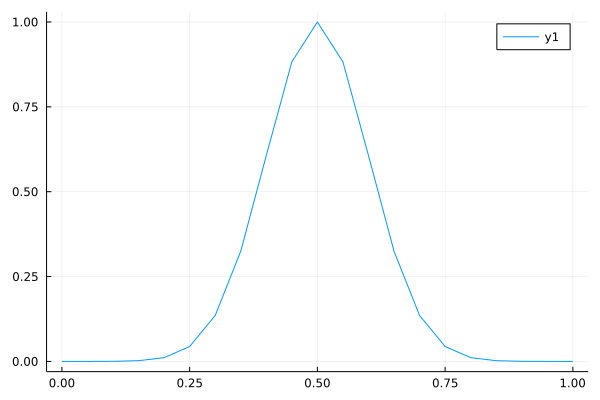

In [48]:
plot(x,u[:,1])

---
# Case 5: Periodic

Going to solve the diffusion equation,
$$
    \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(k \frac{\partial u}{\partial x}\right),
$$
with Dirichlet boundary conditions,
$$
    u(0,t) = \phi_0,  \qquad u(L,t) = \phi_L
$$
and initial condition,
$$
    u(x,0) = \exp(-(x-0.5)^2/0.02).
$$

In [ ]:
function rate(uₓₓ,u,n,Δx,Δt,k,t,x,g;order=2)

    # Compute the second derivative
    uₓₓ = SBP_operators.Dₓₓ!(uₓₓ,u,k,n,Δx,order=order)

    # SAT terms
    SAT = SBP_operators.Dirichlet(u,Δx,g,c=k,order=order)

    uₓₓ[1:order] += SAT[1:order]
    uₓₓ[end-order+1:end] += SAT[end-order+1:end]


    return uₓₓ

end

In [ ]:
# Spatial domain
𝒟 = [0.0,1.0]
n =  51
Δx = 𝒟[2]/(n-1)
x = collect(range(𝒟[1],𝒟[2],step=Δx))

k = zeros(Float64,n+1) .+ 8.0

# Time domain
Δt = 10.0 * Δx^2
t_f = 50*Δt #Length of the simulation
N = ceil(Int64,t_f/Δt) #Time steps in simulation

u₀(x) = exp.(-(x.-0.5).^2 ./0.02) #Set initial condition

ϕ = [1.0,0.0] #Set the boundary conditions

order = 2 #Order of the integrator
method = :impliciteuler #Time stepping method

println("Δx=",Δx,"      ","Δt=",Δt,"        ","final time=",t_f)

In [ ]:
u = zeros(Float64,length(x),N)
u[:,1] = u₀(x)
u[1,1] = ϕ[1]
u[end,1] = ϕ[end]

soln = time_solver(u,rate,n,x,Δt,Δx,k,t_f,ϕ,method=method,order=order);

In [ ]:
anim = @animate for i=1:N
    plot(x,u[:,i],label="t=$(@sprintf("%.5f",i*Δt))")
end


gif(anim,"yes.gif",fps=5)